# ***JOÃO LEME***
# Este notebook é baseado no projeto 1: **trading with momentum** do curso AI for trading da **UDACITY**
## Instruções
Para a realização deste foi feito o download destes datasets do site [kaggle](https://www.kaggle.com/timoboz/stock-data-dow-jones/version/15#_=_). Em seguida, foram pego 10 ações diferentes e concatenado em um unico arquivo. 
(Poderia ser qualquer tipo de timeseries data, optei por estes apenas por facilidade e para fins de estudo).

### **Sumário**
neste notebook você irá ver:
* Resampling data: modificar o horizonte do dataset (diário -> mensal).
* Log Returns: Como calcular e link para descussão.
* Shift Returns: Para obter os retornos com delay de t de 1 e -1 dias.
* Gerar o sinal de trade: Criar portfolio baseado no histórico (comprar ações em alta e vender as em baixa).
* Avaliar os retornos obtidos.
* Fazer o t-test de hipótese.

In [2]:
#IMPORTANDO BIBLIOS
#Manipulação
import pandas as pd
import numpy as np
import datetime
#Plot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['font.size'] = 2
from IPython.core.pylabtools import figsize
sns.set(font_scale = 2)
plt.style.use('seaborn-whitegrid')
# Esconder os erros 
import warnings
warnings.filterwarnings('ignore')
#manipula;áo de data
from datetime import datetime

In [104]:
#Lendo os dado
data = pd.read_csv('close.csv')
#transformando a coluna date para tipo datetime
data['date'] = pd.to_datetime(data['date'])
#tornando a coluna date como index
data.set_index('date',inplace=True)
#visualizando o dataset
data.head()

,AAPLclose,axpclose,catclose,baclose,cscoclose,cvxclose,ibmclose,msftclose,pgclose,xomclose
date,,,,,,,,,,
2014-01-22,72.3087,84.4782,77.5744,126.9742,19.4381,98.5652,158.0505,32.0738,67.7208,81.9883
2014-01-23,72.9210,82.6613,76.7525,124.2829,19.4466,98.6225,152.8669,31.8610,67.4243,81.4722
2014-01-24,71.5955,80.6034,75.7592,120.1844,19.2082,96.9519,153.2695,31.9718,66.5818,80.7147
2014-01-27,72.1763,79.4631,73.7813,120.8089,18.9017,95.2322,150.6777,32.6369,67.3817,78.9501
2014-01-28,66.4074,80.3160,78.1652,120.5714,18.7314,95.3468,149.2182,31.9496,66.7775,79.0084


## Resampling data
O trading signal (métrica para tomada de decisão) que iremos desenvolver neste projeto não precisa ser em horizonte diário.
Os dados deste dataset estão todos em horizonte diário, contudo, caso queira analisar nos horizontes {semanal:week ; mensal:month} basta utilizar a função do pandas **.resample** e pegar o preço do ultimo dia do mês.

In [105]:
#se for semanal; freq = 'W'; se for mensal freq = 'M'
freq='M'
prices_resampled = data.resample(freq).last()
#visualizando
prices_resampled.head()

,AAPLclose,axpclose,catclose,baclose,cscoclose,cvxclose,ibmclose,msftclose,pgclose,xomclose
date,,,,,,,,,,
2014-01-31,65.6339,78.8142,79.8006,110.1668,18.7109,95.3632,148.7653,32.6856,65.4159,78.2343
2014-02-28,69.4085,84.6173,82.7974,114.0253,18.6633,95.5823,156.2519,33.8241,66.5392,80.3392
2014-03-31,70.7934,83.4585,85.1007,110.9916,19.0123,97.9040,160.6206,36.0040,67.8753,81.8984
2014-04-30,77.8300,81.2533,90.6919,114.1137,19.8876,104.0756,164.5507,36.1916,70.7161,85.0419
2014-05-31,83.5559,85.0358,89.2278,120.2952,21.1928,101.9227,155.8808,36.2940,68.9662,85.4674


## Calculando Log Returns

Calcular o log returns ($R_t$) dos preços ($P_t$) sera o primeiro momentum indicador a ser calculado:

$$R_t = log_e(P_t) - log_e(P_{t-1})$$

Caso queira saber mais o porque de usar [log returns?](https://quantivity.wordpress.com/2011/02/21/why-log-returns/).

Iremos utilizar a função do numpy [log function](https://docs.scipy.org/doc/numpy/reference/generated/numpy.log.html).

In [110]:
log_returns = np.log(prices_resampled) - np.log(prices_resampled.shift(1))
#visual...
log_returns.head()

,AAPLclose,axpclose,catclose,baclose,cscoclose,cvxclose,ibmclose,msftclose,pgclose,xomclose
date,,,,,,,,,,
2014-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-28,0.055917,0.071046,0.036866,0.034425,-0.002547,0.002295,0.049100,0.034239,0.017026,0.026550
2014-03-31,0.019756,-0.013789,0.027439,-0.026966,0.018527,0.024000,0.027576,0.062456,0.019881,0.019222
2014-04-30,0.094761,-0.026778,0.063633,0.027741,0.045010,0.061130,0.024174,0.005197,0.041001,0.037665
2014-05-31,0.070989,0.045501,-0.016275,0.052753,0.063565,-0.020903,-0.054127,0.002825,-0.025057,0.004991


Note que temos valores nulos no primeiro mês, isto se deve ao próprio cálculo da diferença, em que no primeiro ($t$) não existe ($t-1$)

## Shift Returns
também podemos utilziar a função shift no dataset de log_return para analizar os retornos anteriores ou posteriores.

In [180]:
#retornos t+1
prev_returns = log_returns.shift(1)
#retornos t-1
lookahead_returns = log_returns.shift(-1)

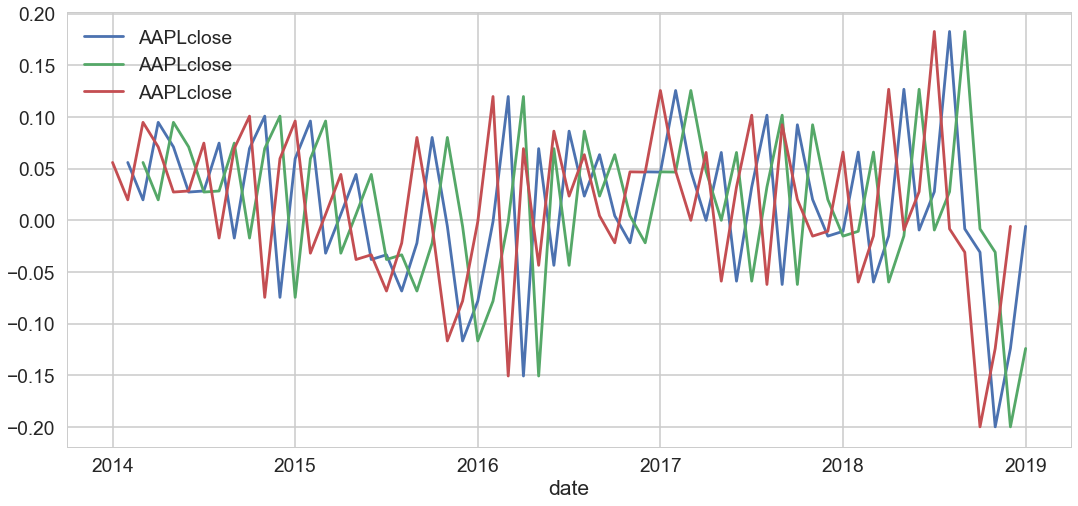

In [138]:
#plotando log_return, prev_returnse lookadheadreturn das ações da APPLE
pd.concat([log_returns['AAPLclose'],prev_returns['AAPLclose'],lookahead_returns['AAPLclose']],axis=1).plot(figsize=(18, 8))

# **GERANDO O SINAL DE TRADE**
Um trading signal é uma sequencia de ações ou resultados, provenientes de alguma estratégia, que possam auxiliar na tomada de decisão para compra (long) ou venda (short) de alguma ação. A ideia desta simples estratégia chamada momentum é criar um portfolio dentre as 10 ações do dataset informando quais as 3 melhores ações para ficar comprado (long) e quais as 3 melhores para ficarmos vendido (short).

*Note: Para isto iremos utilziar as funções do pandas [`DataFrame.iterrows`](https://pandas.pydata.org/pandas-docs/version/0.21/generated/pandas.DataFrame.iterrows.html) com [`Series.nlargest`](https://pandas.pydata.org/pandas-docs/version/0.21/generated/pandas.Series.nlargest.html) para implementar a função de vetorização.*

In [140]:
def get_top_n(prev_returns, top_n):
    # TODO: Implement Function
    #cria um dataframe vazio apenas com as colunas e os index
    top = pd.DataFrame(0, columns = prev_returns.columns, index = prev_returns.index)
    #aplicando a funçãp nlargest para encontrar os top_n maiores retornos na linha
    data = prev_returns.apply(lambda x: x.nlargest(top_n), axis=1)
    #função merge ira juntar os datasets e substituir por valores booleanos
    top = top.merge(data, how = 'right').set_index(data.index)
    #tranformar bool para 0 ou 1 basta multiplicar por 1
    top = top.notnull()*1
    top_stocks = top.astype(int)
    return top_stocks

In [147]:
top_bottom_n = 3
df_long = get_top_n(prev_returns, top_bottom_n)
df_short = get_top_n(-1*prev_returns, top_bottom_n)

In [155]:
#Visualizando
df_long.head()

,AAPLclose,axpclose,catclose,baclose,cscoclose,cvxclose,ibmclose,msftclose,pgclose,xomclose
date,,,,,,,,,,
2014-01-31,0,0,0,0,0,0,0,0,0,0
2014-02-28,0,0,0,0,0,0,0,0,0,0
2014-03-31,1,1,0,0,0,0,1,0,0,0
2014-04-30,0,0,1,0,0,0,1,1,0,0
2014-05-31,1,0,1,0,0,1,0,0,0,0


## Projeção de Returns
Agora é hora de checar se nosso sinal de trade nos dara lucro!
Iremos começar computando onde os sinais são 1, como no print do df_long acima. Para simplificar, também iremos assumir que o dinheiro investido em cada ação sera de mesma quantidade. 
Este é apenas um calculo simples de média artimética individual para cada ação.

In [188]:
def portfolio_returns(df_long, df_short, lookahead_returns, n_stocks):
    # TODO: Implement Function
    #juntando os dois dataframes em um
    amp = (df_long - df_short)
    #multiplicando pelo returno que deu no mês seguinte e dividindo pelo total de ações (compradas + vendidas)
    portfolio_returns = (amp* lookahead_returns)/n_stocks
    return portfolio_returns

In [190]:
expected_portfolio_returns = portfolio_returns(df_long, df_short, lookahead_returns,2*top_bottom_n)

### Visualizando 

Estatistica descritiva por ação

In [191]:
expected_portfolio_returns.describe()

,AAPLclose,axpclose,catclose,baclose,cscoclose,cvxclose,ibmclose,msftclose,pgclose,xomclose
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,0.001489,-0.000679,0.002521,-0.000789,0.001355,0.000195,-0.000007,0.001668,-0.000738,-0.001476
std,0.008711,0.008161,0.010883,0.008645,0.007828,0.008333,0.004766,0.009067,0.004413,0.004638
min,-0.020681,-0.027278,-0.022212,-0.020509,-0.013001,-0.027428,-0.010908,-0.016333,-0.013871,-0.019912
25%,-0.000003,-0.000335,-0.000222,-0.003437,-0.001506,-0.000194,-0.001379,-0.001286,-0.001745,-0.001541
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000
75%,0.004630,0.000000,0.006394,0.000795,0.001552,0.001670,0.000186,0.005073,0.000000,-0.000000
max,0.033319,0.043000,0.042419,0.030612,0.027910,0.022169,0.013897,0.034280,0.011726,0.010043


Geral

In [192]:
expected_portfolio_returns_by_date = expected_portfolio_returns.T.sum().dropna()
portfolio_ret_mean = expected_portfolio_returns_by_date.mean()
portfolio_ret_ste = expected_portfolio_returns_by_date.sem()
portfolio_ret_annual_rate = (np.exp(portfolio_ret_mean * 12) - 1) * 100

print("""
Média:                       {:.6f}
Desvio Padrão:             {:.6f}
Retorno médio Anual (%):  {:.2f}%
""".format(portfolio_ret_mean, portfolio_ret_ste, portfolio_ret_annual_rate))


Média:                       0.003482
Desvio Padrão:             0.002450
Retorno médio Anual (%):  4.27%



### T-Teste

Para saber mais sobre [t-test](https://pt.wikipedia.org/wiki/Teste_t_de_Student).

Neste projeto iremos utilizar  $\alpha = 0.05$, que é o mais comum a ser utilziado.

Note: scipy.stats.ttest_1samp funciona com two-sided test, então temos que dividir p-valor por 2 para termos 1-sided do p-valor.


In [193]:
from scipy import stats
def analyze_alpha(expected_portfolio_returns_by_date):
    # TODO: Implement Function
    null_hypothesis = 0.0
    t,p = stats.ttest_1samp(expected_portfolio_returns_by_date, null_hypothesis)
    return t,p/2

In [194]:
t_value, p_value = analyze_alpha(expected_portfolio_returns_by_date)
print("""
Alpha análise:
 t-value:        {:.3f}
 p-value:        {:.6f}
""".format(t_value, p_value))


Alpha análise:
 t-value:        1.421
 p-value:        0.080270



### Questão: Sobre o p-valor obtido, o que este indica do sinal?
O teste de hipótese retornou um valor $p > \alpha$, desse modo, não podemos rejeitar a hipótese nula. Assim, pode se concluir do teste-t que nosso sinal não nos fornece retornos positivos.

The hypothesis test returned a value $p > \alpha$, so we can't reject the null hypothesis. Thus, it can be concluded from t-test that our signal does not give us positive returns.